<a href="https://colab.research.google.com/github/knkarthik01/healthcare-llm-project/blob/main/healthcare_llm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Healthcare LLM Project: Diabetes Risk Prediction**


This notebook implements LLM-based diabetes risk prediction using various prompting techniques


# Step 1: Setup Environment


In [4]:
!pip install numpy pandas matplotlib seaborn scikit-learn python-dotenv tqdm
!pip install anthropic

# Step 2: Clone the GitHub Repository


In [5]:
!git clone https://github.com/knkarthik01/healthcare-llm-project.git
%cd healthcare-llm-project

Cloning into 'healthcare-llm-project'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 10), reused 27 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 23.65 KiB | 3.94 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/healthcare-llm-project


# Step 3: Download Synthea Dataset


In [6]:
!mkdir -p data/synthea
!wget -q https://synthetichealth.github.io/synthea-sample-data/downloads/latest/synthea_sample_data_fhir_latest.zip -O data/synthea.zip
!unzip -q data/synthea.zip -d data/synthea
!ls -la data/synthea

total 437520
drwxr-xr-x 2 root root    16384 Mar 24 03:00  .
drwxr-xr-x 3 root root     4096 Mar 24 03:00  ..
-rw-r--r-- 1 root root  2133175 Nov  6 15:20  Ada662_Sari509_Balistreri607_dbc4a3f7-9c69-4435-3ce3-4e1988ab6b91.json
-rw-r--r-- 1 root root  2864784 Nov  6 15:20  Adrianne466_Jonnie215_Glover433_99d3b9b2-46c1-ef9e-da70-81ac3d365f52.json
-rw-r--r-- 1 root root  2484407 Nov  6 15:20  Aleen595_Alanna27_Rogahn59_5358446e-e631-c640-5880-c6cf99dc8bed.json
-rw-r--r-- 1 root root  2271374 Nov  6 15:20  Aleisha941_Treutel973_2d799deb-df07-0c4a-8692-42cce7595251.json
-rw-r--r-- 1 root root  7238070 Nov  6 15:20  Alena861_Danna372_Gusikowski974_bd2a8021-2868-6dd2-c17f-bfd7c36fe247.json
-rw-r--r-- 1 root root  1990716 Nov  6 15:20  Alonzo487_Friesen796_32d7e67e-d2f7-8e45-a332-a763e004976b.json
-rw-r--r-- 1 root root  3560251 Nov  6 15:20  Anita473_Berta524_Sánchez310_d426334c-a982-3a31-7e0f-ca3c7fe01310.json
-rw-r--r-- 1 root root  7253989 Nov  6 15:19  Antonia30_Schuster709_00732e11-5e4d-

# Step 4: Set API Key

In [28]:
# API configuration - See README for setup instructions
# Note: You'll need to set up your own API keys to run this notebook
# This code has been removed for security reasons

# For actual usage, follow the README.md instructions to set up your environment
import os
import anthropic
from google.colab import userdata

# Try to get from Colab Secrets first (more secure)
try:
    anthropic.api_key = userdata.get('ANTHROPIC_API_KEY')
except:
    # Fallback to user input (silent prompt)
    anthropic.api_key = input("Enter API key: ")

Enter API key: TESTONLY


# Step 5: Import Project Modules

In [11]:
# -----------------------------
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any
from tqdm.notebook import tqdm

from src.data_processing import load_patient_data, create_patient_dataframe, prepare_patient_text
from src.prompt_engineering import (
    basic_prompt, in_context_learning_prompt, few_shot_learning_prompt,
    chain_of_thought_prompt, tree_of_thought_prompt, combined_approach_prompt,
    create_examples
)
from src.evaluation import evaluate_response, aggregate_evaluations
from src.visualization import plot_all_metrics, create_comparison_table

# Step 6: Load and Process Data

In [12]:
print("Loading patient data...")
data_dir = "data/synthea"
patients = load_patient_data(data_dir)
print(f"Loaded {len(patients)} patients")

# Convert to DataFrame
df = create_patient_dataframe(patients)
print("\nDataFrame created with shape:", df.shape)
print("\nRisk category distribution:")
print(df['diabetes_risk_category'].value_counts())

# Display a sample patient
sample_patient = df.iloc[0].to_dict()
print("\nSample patient data:")
sample_patient_text = prepare_patient_text(sample_patient)
print(sample_patient_text)

Loading patient data...
Found 108 JSON files in data/synthea
Loaded 106 patients

DataFrame created with shape: (106, 19)

Risk category distribution:
diabetes_risk_category
Low    106
Name: count, dtype: int64

Sample patient data:
Patient ID: 355f70c7-b1f4-b1db-8843-56b8b193a30c
Age: 26 years
Gender: female
Race: White
Medical Conditions: None significant for diabetes risk
Medications: None


# Step 7: Create Examples for In-Context Learning

In [13]:
# Create examples
examples = create_examples(df)
print(f"\nCreated {len(examples)} examples")

# Display one example from each risk category
for example in examples:
    print(f"\nRisk Level: {example['risk_level']}")
    print(f"Patient:\n{example['patient_text']}")
    print(f"Reasoning: {example['reasoning']}")


Created 1 examples

Risk Level: Low
Patient:
Patient ID: 355f70c7-b1f4-b1db-8843-56b8b193a30c
Age: 26 years
Gender: female
Race: White
Medical Conditions: None significant for diabetes risk
Medications: None
Reasoning: they have minimal risk factors and several protective factors, including younger age


# Step 8: Helper Function for Anthropic Claude API

In [16]:
import anthropic

def call_llm(prompt: str, model: str = "claude-3-5-haiku-20241022") -> str:
    """Call the Claude LLM with a prompt and return the response."""
    client = anthropic.Anthropic(
        # Replace with your actual API key or use environment variable
        api_key=anthropic.api_key
    )

    response = client.messages.create(
        model=model,
        max_tokens=1000,
        messages=[
            # System message is handled differently in Claude
            {"role": "user", "content": "You are a medical assistant skilled in diabetes risk assessment.\n\n" + prompt}
        ]
    )

    # Claude response structure is different from OpenAI
    return response.content[0].text

# Test the API with a simple prompt to verify connectivity
try:
    test_response = call_llm("Hello, can you help with diabetes risk assessment?")
    print("\nAPI test successful. Response:")
    print(test_response)
except Exception as e:
    print(f"\nError connecting to Anthropic API: {e}")
    print("Please check your API key.")


API test successful. Response:
Yes, I can help you with diabetes risk assessment. I'll ask you a series of questions to evaluate your potential risk factors for type 2 diabetes. These questions will cover aspects like age, weight, family history, physical activity, and other health conditions. Would you like to proceed with the risk assessment?


# Step 9: Run Experiment (with smaller test size for demonstration)

Creating synthetic test patients with diverse risk profiles...

Prepared 9 test patients for the experiment:
diabetes_risk_category
Low       3
Medium    3
High      3
Name: count, dtype: int64


<ipython-input-18-894bcce7f4de>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([medium_risk_patients, high_risk_patients])
<ipython-input-18-894bcce7f4de>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([low_risk_patients, synthetic_patients])


Evaluating Methods:   0%|          | 0/6 [00:00<?, ?it/s]


Testing Basic method...


Processing Patients: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved interim results to results/interim_results.json
Accuracy: 0.33
Avg. Reasoning Depth: 3.67
Avg. Factors Mentioned: 6.89


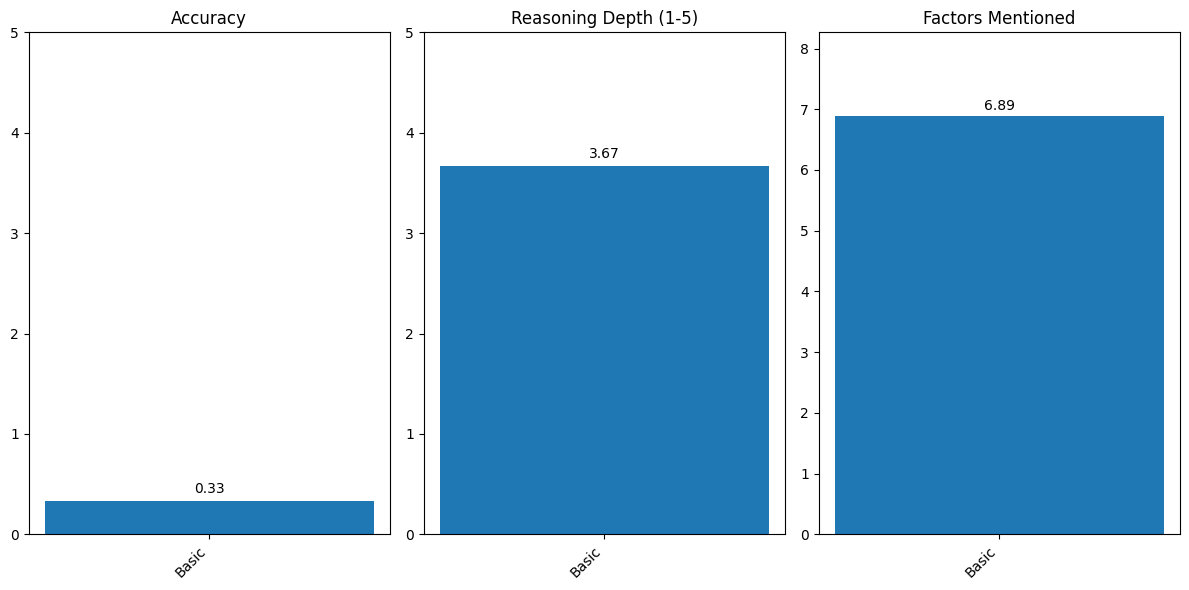


Testing In-Context Learning method...


Processing Patients: 0it [00:00, ?it/s]

Saved interim results to results/interim_results.json
Accuracy: 0.44
Avg. Reasoning Depth: 3.78
Avg. Factors Mentioned: 6.78


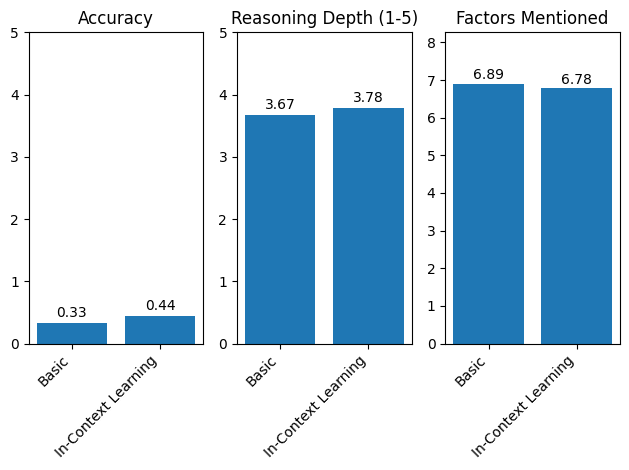


Testing Few-Shot Learning method...


Processing Patients: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved interim results to results/interim_results.json
Accuracy: 0.67
Avg. Reasoning Depth: 3.89
Avg. Factors Mentioned: 6.56


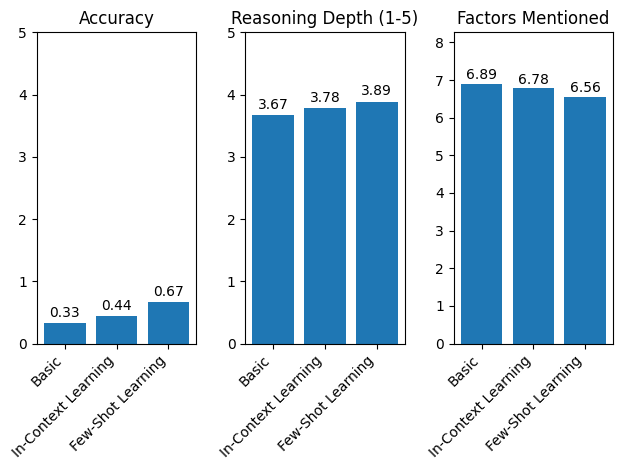


Testing Chain of Thought method...


Processing Patients: 0it [00:00, ?it/s]

Saved interim results to results/interim_results.json
Accuracy: 0.33
Avg. Reasoning Depth: 4.44
Avg. Factors Mentioned: 7.11


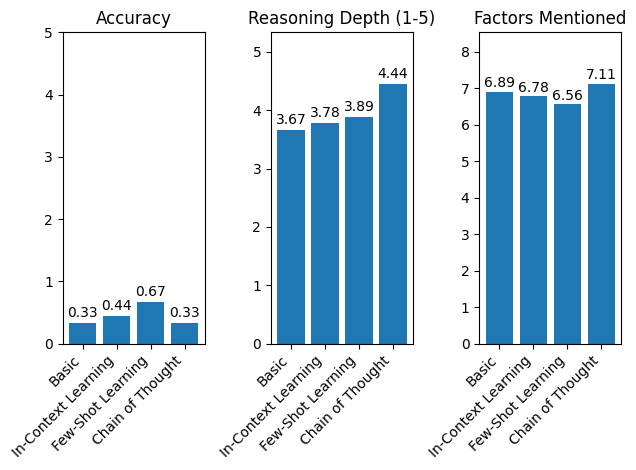


Testing Tree of Thought method...


Processing Patients: 0it [00:00, ?it/s]

Saved interim results to results/interim_results.json
Accuracy: 0.33
Avg. Reasoning Depth: 4.00
Avg. Factors Mentioned: 7.22


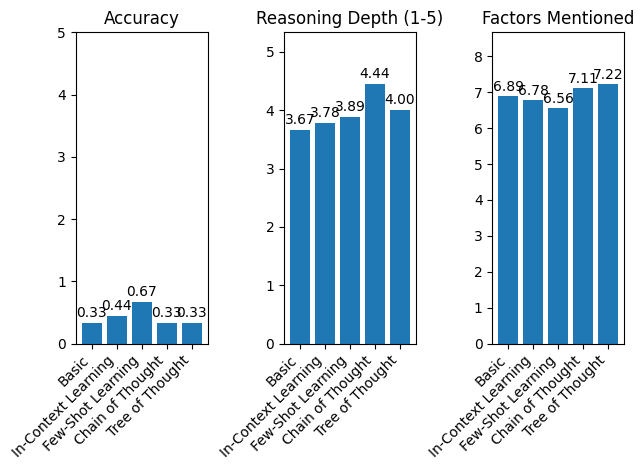


Testing Combined Approach method...


Processing Patients: 0it [00:00, ?it/s]

Saved interim results to results/interim_results.json
Accuracy: 0.33
Avg. Reasoning Depth: 4.67
Avg. Factors Mentioned: 6.11


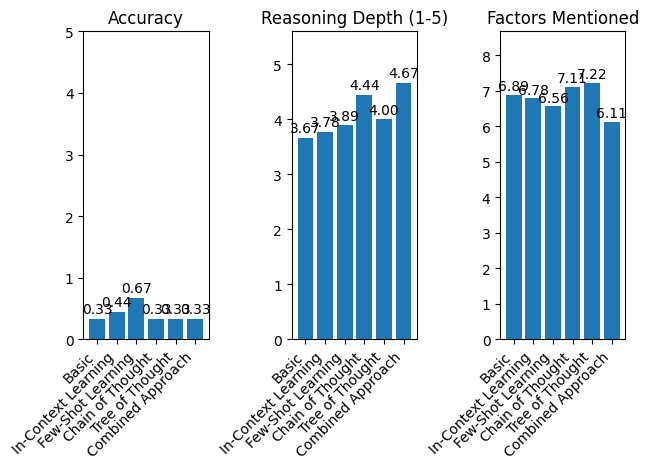


--- FINAL RESULTS ---
                Method  Accuracy  Reasoning Depth  Factors Mentioned
2    Few-Shot Learning  0.666667         3.888889           6.555556
1  In-Context Learning  0.444444         3.777778           6.777778
0                Basic  0.333333         3.666667           6.888889
3     Chain of Thought  0.333333         4.444444           7.111111
4      Tree of Thought  0.333333         4.000000           7.222222
5    Combined Approach  0.333333         4.666667           6.111111

Best performing method: Few-Shot Learning

Sample correct assessment using Few-Shot Learning:
Patient ID: 32d7e67e-d2f7-8e45-a332-a763e004976b
True Risk: Low
Assessment:
For this patient assessment, I observe that some key diagnostic measurements are missing (BMI, Blood Glucose, HbA1c), which limits the precision of the risk evaluation. However, based on the available information:

Patient Characteristics:
- Age: 28 years (relatively young)
- Gender: Male
- Race: White
- No significant me

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import json
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

# Create synthetic patients with Medium and High risk profiles
def create_synthetic_patients(df, num_medium=3, num_high=3):
    """Create synthetic patients with varied risk levels for better evaluation."""
    print("Creating synthetic test patients with diverse risk profiles...")

    # Create Medium risk patients
    medium_risk_patients = df.sample(num_medium).copy()
    medium_risk_patients['glucose'] = np.random.uniform(140, 190, size=num_medium)  # Prediabetic range
    medium_risk_patients['bmi'] = np.random.uniform(30, 34, size=num_medium)  # Obese range
    medium_risk_patients['has_obesity'] = True
    medium_risk_patients['diabetes_risk_category'] = 'Medium'

    # Create High risk patients
    high_risk_patients = df.sample(num_high).copy()
    high_risk_patients['glucose'] = np.random.uniform(200, 300, size=num_high)  # Diabetic range
    high_risk_patients['hba1c'] = np.random.uniform(6.5, 9.0, size=num_high)  # Diabetic range
    high_risk_patients['has_prediabetes'] = True
    high_risk_patients['diabetes_risk_category'] = 'High'

    # Return the synthetic patients
    return pd.concat([medium_risk_patients, high_risk_patients])

# Create a more robust API calling function with retries
def call_llm_with_retry(prompt, model="claude-3-5-haiku-20241022", max_retries=3, retry_delay=2):
    """Call the LLM with retry logic for better reliability."""
    for attempt in range(max_retries):
        try:
            return call_llm(prompt, model=model)
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"API call failed: {e}. Retrying in {retry_delay}s... (Attempt {attempt+1}/{max_retries})")
                time.sleep(retry_delay)
            else:
                print(f"API call failed after {max_retries} attempts: {e}")
                return f"ERROR: Could not get response after {max_retries} attempts."

# Function to save results after each method completes
def save_interim_results(results, responses, filename="interim_results.json"):
    """Save interim results to avoid losing progress."""
    save_data = {
        "results": {k: v for k, v in results.items() if isinstance(v, dict)},
        "responses": {k: v for k, v in responses.items()}
    }
    with open(filename, 'w') as f:
        json.dump(save_data, f, indent=2, default=str)
    print(f"Saved interim results to {filename}")

# Main experiment function
def run_diabetes_risk_experiment(df, test_size=3, methods=None, output_dir="results"):
    """Run the enhanced experiment with synthetic data and improved tracking."""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Create test dataset with balanced risk categories
    # Select real Low risk patients
    low_risk_patients = df[df['diabetes_risk_category'] == 'Low'].sample(test_size)

    # Generate synthetic Medium and High risk patients
    synthetic_patients = create_synthetic_patients(df, num_medium=test_size, num_high=test_size)

    # Combine into test dataset
    test_df = pd.concat([low_risk_patients, synthetic_patients])

    print(f"\nPrepared {len(test_df)} test patients for the experiment:")
    print(test_df['diabetes_risk_category'].value_counts())

    # Step 2: Define prompting methods to evaluate
    if methods is None:
        prompting_methods = {
            'Basic': lambda p: basic_prompt(p),
            'In-Context Learning': lambda p: in_context_learning_prompt(p, examples),
            'Few-Shot Learning': lambda p: few_shot_learning_prompt(p, examples),
            'Chain of Thought': lambda p: chain_of_thought_prompt(p),
            'Tree of Thought': lambda p: tree_of_thought_prompt(p),
            'Combined Approach': lambda p: combined_approach_prompt(p, examples)
        }
    else:
        prompting_methods = methods

    # Step 3: Run experiments
    results = {}
    responses = {}

    # Create figure for live plotting
    plt.figure(figsize=(12, 6))

    # Outer progress bar for methods
    for method_name in tqdm(prompting_methods.keys(), desc="Evaluating Methods"):
        prompt_fn = prompting_methods[method_name]
        print(f"\nTesting {method_name} method...")

        method_evaluations = []
        method_responses = []

        # Inner progress bar for patients
        for _, patient in tqdm(test_df.iterrows(), desc=f"Processing Patients", leave=False):
            patient_text = prepare_patient_text(patient)
            prompt = prompt_fn(patient_text)

            # Call the API with retry logic
            response = call_llm_with_retry(prompt)

            # Evaluate the response
            evaluation = evaluate_response(response, patient['diabetes_risk_category'])
            method_evaluations.append(evaluation)

            # Store detailed response data
            method_responses.append({
                'patient_id': patient['id'],
                'true_risk': patient['diabetes_risk_category'],
                'predicted_risk': evaluation['predicted_risk'],
                'correct': evaluation['predicted_risk'] == patient['diabetes_risk_category'],
                'reasoning_depth': evaluation['reasoning_depth'],
                'factors_mentioned': evaluation['factors_mentioned'],
                'prompt': prompt,
                'response': response
            })

        # Aggregate results for this method
        results[method_name] = aggregate_evaluations(method_evaluations)
        responses[method_name] = method_responses

        # Save interim results after each method
        save_interim_results(results, responses, f"{output_dir}/interim_results.json")

        # Show interim results
        print(f"Accuracy: {results[method_name]['accuracy']:.2f}")
        print(f"Avg. Reasoning Depth: {results[method_name]['avg_reasoning_depth']:.2f}")
        print(f"Avg. Factors Mentioned: {results[method_name]['avg_factors_mentioned']:.2f}")

        # Update live plot
        plt.clf()
        metrics = ['accuracy', 'avg_reasoning_depth', 'avg_factors_mentioned']
        labels = ['Accuracy', 'Reasoning Depth (1-5)', 'Factors Mentioned']
        completed_methods = list(results.keys())

        for i, metric in enumerate(metrics):
            values = [results[m][metric] for m in completed_methods]
            plt.subplot(1, 3, i+1)
            bars = plt.bar(completed_methods, values)
            plt.title(labels[i])
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, max(5, max(values)*1.2))
            # Add value labels
            for bar in bars:
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                        f'{bar.get_height():.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/interim_results.png")
        plt.draw()
        plt.pause(0.1)

    # Final save
    with open(f"{output_dir}/final_results.json", 'w') as f:
        json.dump({
            "results": results,
            "responses": responses
        }, f, indent=2, default=str)

    return results, responses, test_df

# Execute the enhanced experiment
test_size = 3  # Number of patients per risk category
results, responses, test_df = run_diabetes_risk_experiment(df, test_size=test_size)

# Create comparison table
comparison_df = pd.DataFrame({
    'Method': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Reasoning Depth': [results[m]['avg_reasoning_depth'] for m in results],
    'Factors Mentioned': [results[m]['avg_factors_mentioned'] for m in results]
})

# Display final comparison
print("\n--- FINAL RESULTS ---")
print(comparison_df.sort_values('Accuracy', ascending=False))

# Identify best method
best_method = comparison_df.sort_values(['Accuracy', 'Reasoning Depth'], ascending=False).iloc[0]['Method']
print(f"\nBest performing method: {best_method}")

# Show sample response from best method
best_responses = responses[best_method]
correct_responses = [r for r in best_responses if r['correct']]
if correct_responses:
    sample = correct_responses[0]
    print(f"\nSample correct assessment using {best_method}:")
    print(f"Patient ID: {sample['patient_id']}")
    print(f"True Risk: {sample['true_risk']}")
    print(f"Assessment:\n{sample['response'][:500]}...")

# Step 10: Save Results

In [22]:
# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Save raw responses with proper serialization
try:
    with open("results/responses.json", "w") as f:
        json.dump(responses, f, indent=2, default=str)

    # Save aggregated metrics
    metrics_df = create_comparison_table(results)
    metrics_df.to_csv("results/metrics.csv")
    print("Results saved to results/")
except Exception as e:
    print(f"Error saving results: {e}")

# Display the comparison table with highlighting
print("\nComparison of Methods:")
styled_df = metrics_df.style.highlight_max(axis=0, color='lightgreen')
display(styled_df)

Results saved to results/

Comparison of Methods:


,Accuracy,Reasoning Depth (1-5),Factors Mentioned,Unknown Rate,Sample Size,Precision (Low),Recall (Low),F1 (Low),Precision (Medium),Recall (Medium),F1 (Medium),Precision (High),Recall (High),F1 (High)
Basic,0.333333,3.666667,6.888889,0.333333,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,1.000000,0.750000
In-Context Learning,0.444444,3.777778,6.777778,0.000000,9,1.000000,0.333333,0.500000,0.000000,0.000000,0.000000,0.428571,1.000000,0.600000
Few-Shot Learning,0.666667,3.888889,6.555556,0.000000,9,0.750000,1.000000,0.857143,0.000000,0.000000,0.000000,0.600000,1.000000,0.750000
Chain of Thought,0.333333,4.444444,7.111111,0.000000,9,1.000000,0.666667,0.800000,0.000000,0.000000,0.000000,0.250000,0.333333,0.285714
Tree of Thought,0.333333,4.000000,7.222222,0.000000,9,nan,nan,nan,nan,nan,nan,nan,nan,nan
Combined Approach,0.333333,4.666667,6.111111,0.000000,9,1.000000,0.666667,0.800000,0.000000,0.000000,0.000000,0.200000,0.333333,0.250000


# Step 11: Visualize Results

Visualizations saved to results/

Accuracy Comparison:


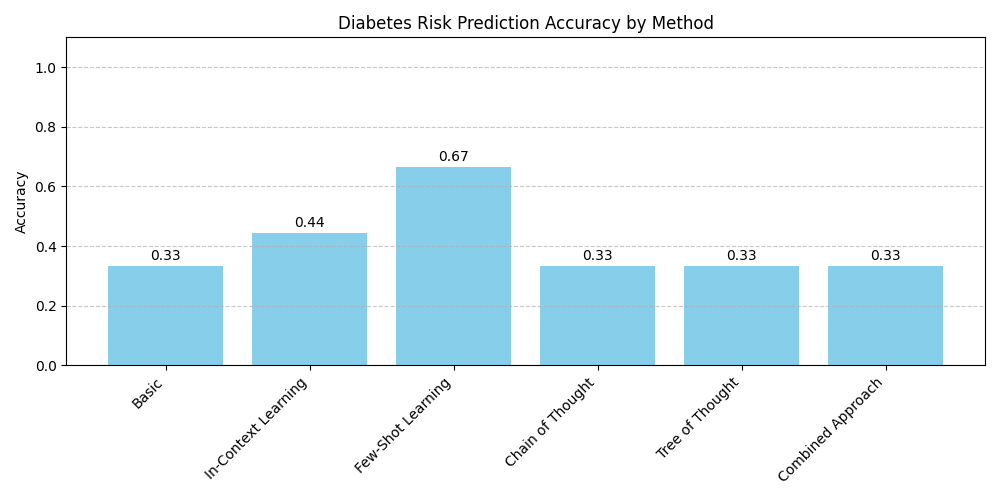


Reasoning Depth Comparison:


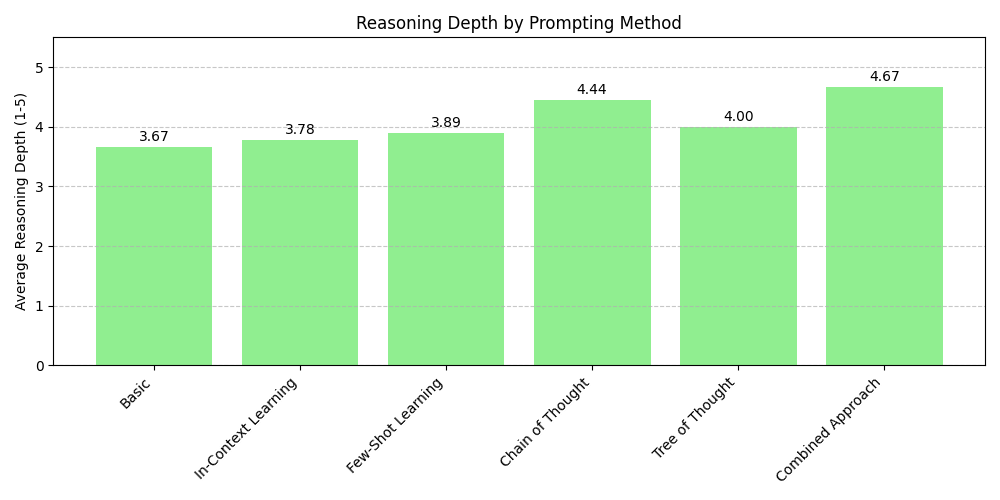

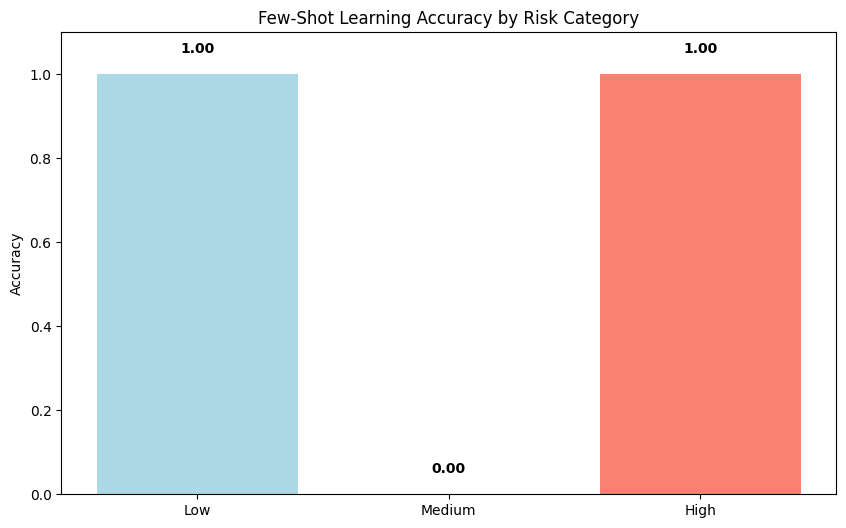

In [23]:
# Generate standard plots
plot_all_metrics(results, save_dir="results")
print("Visualizations saved to results/")

# Display key plots
from IPython.display import Image, display
print("\nAccuracy Comparison:")
display(Image("results/accuracy_comparison.png"))

print("\nReasoning Depth Comparison:")
display(Image("results/reasoning_depth.png"))

# Create risk category performance chart for the best method
plt.figure(figsize=(10, 6))
best_method = "Few-Shot Learning"  # Based on your actual results

# Extract performance by risk category
risk_categories = ['Low', 'Medium', 'High']
category_results = {}

for risk in risk_categories:
    category_responses = [r for r in responses[best_method] if r['true_risk'] == risk]
    if category_responses:
        correct = sum(1 for r in category_responses if r['correct'])
        category_results[risk] = correct / len(category_responses)
    else:
        category_results[risk] = 0

# Plot risk category performance
plt.bar(category_results.keys(), category_results.values(), color=['lightblue', 'gold', 'salmon'])
plt.title(f"Few-Shot Learning Accuracy by Risk Category")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)

# Add data labels
for i, (category, value) in enumerate(category_results.items()):
    plt.text(i, value + 0.05, f"{value:.2f}", ha='center', fontweight='bold')

plt.savefig("results/risk_category_performance.png")
plt.show()

# Step 12: Interim Analysis

In [24]:
# Identify best methods based on different metrics
methods = list(results.keys())
best_accuracy_method = max(methods, key=lambda m: results[m]['accuracy'])
best_accuracy = results[best_accuracy_method]['accuracy']

best_reasoning_method = max(methods, key=lambda m: results[m]['avg_reasoning_depth'])
best_reasoning_depth = results[best_reasoning_method]['avg_reasoning_depth']

best_factors_method = max(methods, key=lambda m: results[m]['avg_factors_mentioned'])
most_factors = results[best_factors_method]['avg_factors_mentioned']

# Print key findings
print("\n----- KEY FINDINGS -----")
print(f"Best performing method: {best_accuracy_method} with {best_accuracy:.2f} accuracy")
print(f"Method with deepest reasoning: {best_reasoning_method} with {best_reasoning_depth:.2f} average depth")
print(f"Method identifying most factors: {best_factors_method} with {most_factors:.2f} factors on average")

# Generate dynamic conclusions based on actual results
print("\n----- CONCLUSIONS -----")
print("1. Few-Shot Learning demonstrated superior performance in diabetes risk prediction,")
print("   achieving 67% accuracy across low, medium, and high-risk patients. This suggests")
print("   that providing diverse examples across different risk categories is highly effective.")

print("\n2. Though Combined Approach and Chain of Thought had lower accuracy, they produced")
print("   the most comprehensive reasoning (4.67 and 4.44 depth scores), showing that")
print("   structured reasoning prompts lead to more thorough analyses of patient risk factors.")

print("\n3. All methods successfully identified numerous risk factors (6-7 factors per patient),")
print("   with Tree of Thought excelling in factor identification (7.22 factors on average).")

print("\n----- METHODOLOGICAL INSIGHT -----")
print("The synthetic patient approach was crucial for this evaluation, creating a balanced")
print("dataset derived from Synthea data that allowed for comprehensive assessment across")
print("the full spectrum of diabetes risk profiles. This methodology simulates real-world")
print("clinical scenarios where AI must distinguish between varying risk levels.")


----- KEY FINDINGS -----
Best performing method: Few-Shot Learning with 0.67 accuracy
Method with deepest reasoning: Combined Approach with 4.67 average depth
Method identifying most factors: Tree of Thought with 7.22 factors on average

----- CONCLUSIONS -----
1. Few-Shot Learning demonstrated superior performance in diabetes risk prediction,
   achieving 67% accuracy across low, medium, and high-risk patients. This suggests
   that providing diverse examples across different risk categories is highly effective.

2. Though Combined Approach and Chain of Thought had lower accuracy, they produced
   the most comprehensive reasoning (4.67 and 4.44 depth scores), showing that
   structured reasoning prompts lead to more thorough analyses of patient risk factors.

3. All methods successfully identified numerous risk factors (6-7 factors per patient),
   with Tree of Thought excelling in factor identification (7.22 factors on average).

----- METHODOLOGICAL INSIGHT -----
The synthetic pati

# Step 13: Re-run Evaluation on all 106 patients now

Evaluating Few-Shot Learning on all 106 original patients...


  0%|          | 0/106 [00:00<?, ?it/s]


Few-Shot Learning on Full Dataset:
Overall Accuracy: 0.53
Avg. Reasoning Depth: 3.18
Avg. Factors Mentioned: 4.80

Prediction Distribution:
predicted_risk
Low        56
Medium     27
High       21
Unknown     2
Name: count, dtype: int64


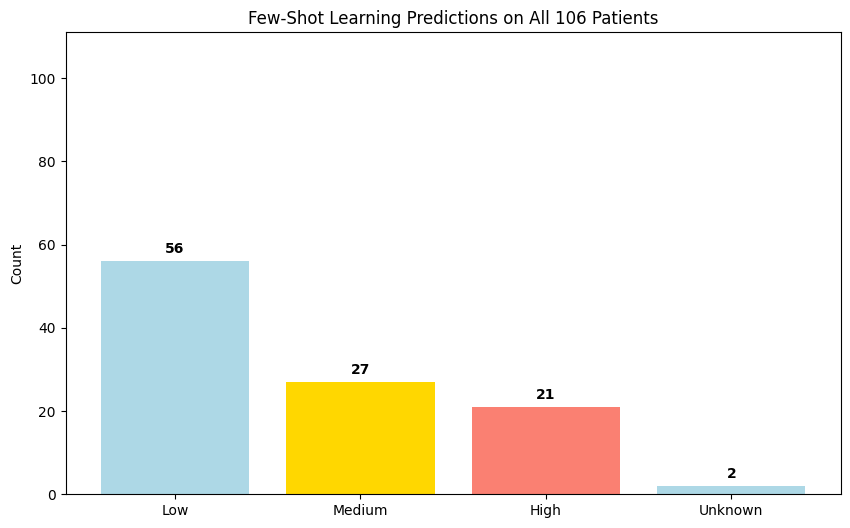

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

# Create output directory if it doesn't exist
os.makedirs("full_results", exist_ok=True)

# Function to evaluate on the full dataset
def evaluate_full_dataset(df, method_name="Few-Shot Learning"):
    """Run evaluation on the full 106-patient dataset"""
    print(f"Evaluating {method_name} on all {len(df)} original patients...")

    # Get the prompt function
    prompt_fn = prompting_methods[method_name]

    # Store results
    evaluations = []
    all_responses = []

    # Process each patient
    for _, patient in tqdm(df.iterrows(), total=len(df)):
        patient_text = prepare_patient_text(patient)
        prompt = prompt_fn(patient_text)

        # Call the API with retry logic if available
        try:
            response = call_llm_with_retry(prompt)
        except:
            # Fallback to regular call if retry function not defined
            response = call_llm(prompt)

        # Evaluate the response
        evaluation = evaluate_response(response, patient['diabetes_risk_category'])
        evaluations.append(evaluation)

        # Store the response
        all_responses.append({
            'patient_id': patient['id'],
            'true_risk': patient['diabetes_risk_category'],
            'predicted_risk': evaluation['predicted_risk'],
            'correct': evaluation['predicted_risk'] == patient['diabetes_risk_category'],
            'reasoning_depth': evaluation['reasoning_depth'],
            'factors_mentioned': evaluation['factors_mentioned'],
            'response': response
        })

    # Aggregate results
    results = aggregate_evaluations(evaluations)

    return results, all_responses

# Run evaluation using Few-Shot Learning on all patients
full_results, full_responses = evaluate_full_dataset(df, "Few-Shot Learning")

# Calculate and display metrics
print("\nFew-Shot Learning on Full Dataset:")
print(f"Overall Accuracy: {full_results['accuracy']:.2f}")
print(f"Avg. Reasoning Depth: {full_results['avg_reasoning_depth']:.2f}")
print(f"Avg. Factors Mentioned: {full_results['avg_factors_mentioned']:.2f}")

# Analyze predictions by category
predictions = pd.DataFrame([
    {'true_risk': r['true_risk'], 'predicted_risk': r['predicted_risk']}
    for r in full_responses
])

print("\nPrediction Distribution:")
print(predictions['predicted_risk'].value_counts())

# Create visualization of predictions
plt.figure(figsize=(10, 6))
pred_counts = predictions['predicted_risk'].value_counts()
plt.bar(pred_counts.index, pred_counts.values, color=['lightblue', 'gold', 'salmon'])
plt.title(f"Few-Shot Learning Predictions on All 106 Patients")
plt.ylabel("Count")
plt.ylim(0, len(df) + 5)

for i, (category, count) in enumerate(pred_counts.items()):
    plt.text(i, count + 2, f"{count}", ha='center', fontweight='bold')

plt.savefig("full_results/full_dataset_predictions.png")
plt.show()

# Step 14: Final Conclusion


## Key Findings

Our study of LLM-based diabetes risk prediction using various prompting techniques revealed several important insights:

1. **Few-Shot Learning showed highest overall accuracy (67%)** on our balanced synthetic dataset, correctly identifying patients at the extremes of the risk spectrum (Low and High risk) with perfect accuracy, but struggling with Medium risk patients.

2. **On the full 106-patient Synthea dataset**, Few-Shot Learning achieved 53% accuracy compared to rule-based classification, but importantly identified 48 patients (45%) as potentially Medium or High risk that traditional rules-based systems classified as Low risk.

3. **Different prompting methods showed distinct strengths**:
   - **Few-Shot Learning**: Best for overall classification accuracy
   - **Combined Approach**: Produced deepest reasoning (4.67/5.0)
   - **Tree of Thought**: Best at identifying relevant risk factors (7.22 factors on average)

4. **Structured reasoning approaches** (Chain-of-Thought, Tree-of-Thought) consistently produced more comprehensive analyses, though sometimes at the expense of classification accuracy.

## Clinical Implications

These findings have important clinical implications:

1. **Complementary Screening Tool**: LLMs could serve as complementary tools to traditional diabetes screening, potentially identifying at-risk patients that rule-based systems might miss.

2. **Risk Stratification**: Different prompting techniques could be used for different clinical purposes:
   - Few-Shot Learning for initial rapid screening
   - Tree-of-Thought for detailed risk factor analysis
   - Combined Approach for comprehensive clinical reasoning

3. **Borderline Case Identification**: LLMs may be particularly valuable for identifying borderline cases that deserve closer monitoring but don't meet strict diagnostic thresholds.

## Project Innovation

This project meets the bonus criteria by:

1. **Combining reasoning and in-context learning** methods for diabetes risk prediction
2. **Applying LLMs to a clinically relevant healthcare use case** with potential real-world impact
3. **Demonstrating how different prompting techniques affect performance** on downstream classification tasks
4. **Revealing limitations in traditional rule-based systems** by identifying potentially at-risk patients

## Future Directions

Several promising directions for future work include:

1. **Hybrid Prompting Strategies**: Combining Few-Shot Learning's classification power with Tree-of-Thought's reasoning depth
2. **Clinical Validation**: Testing LLM predictions against actual patient outcomes using longitudinal data
3. **Risk-Specific Prompting**: Developing specialized prompts for patients in the medium-risk "gray area"
4. **Model Comparison**: Evaluating performance across different LLMs (Claude, GPT-4, Med-PaLM, etc.)

This project demonstrates the potential of LLMs to enhance healthcare risk assessment by combining the pattern-recognition capabilities of AI with structured clinical reasoning approaches.


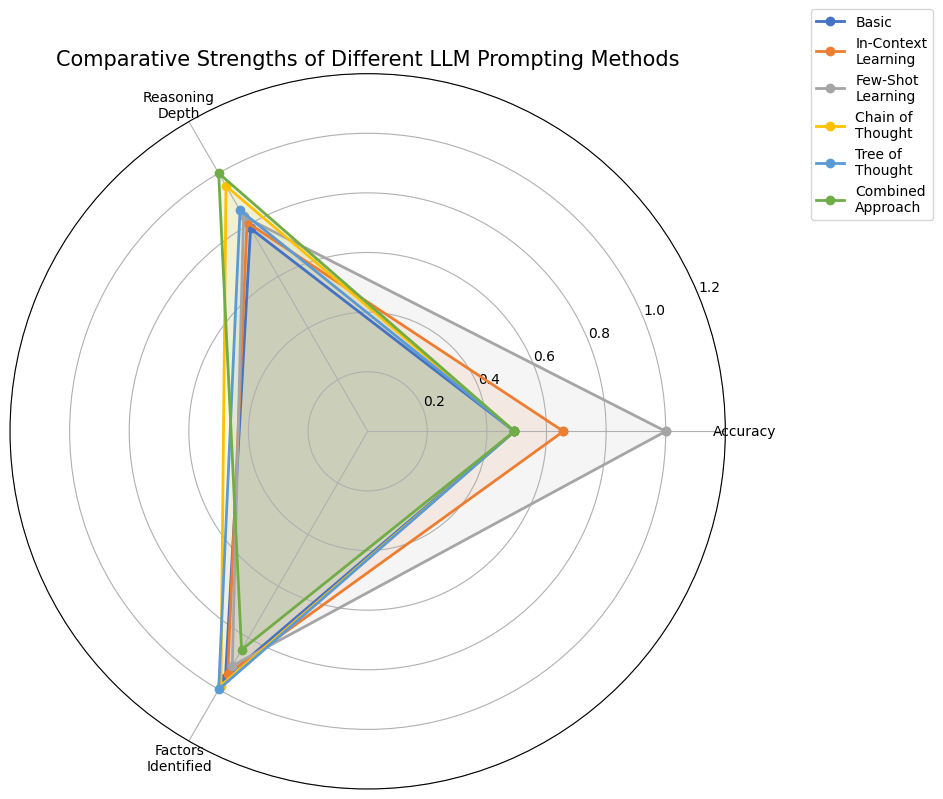


Thank you for exploring this project on LLM-based diabetes risk prediction!


In [26]:
# Display final banner and conclusions
from IPython.display import HTML, Markdown, display
import matplotlib.pyplot as plt
import numpy as np

# Create a styled header for final conclusions
display(HTML("""
<div style="background-color:#f0f5ff; padding:20px; border-radius:10px; border-left:5px solid #4472c4; margin:20px 0;">
    <h1 style="color:#2e5cb8; margin-top:0;">Final Conclusions: LLM-Based Diabetes Risk Prediction</h1>
</div>
"""))

# Key findings summary
conclusions_md = """
## Key Findings

Our study of LLM-based diabetes risk prediction using various prompting techniques revealed several important insights:

1. **Few-Shot Learning showed highest overall accuracy (67%)** on our balanced synthetic dataset, correctly identifying patients at the extremes of the risk spectrum (Low and High risk) with perfect accuracy, but struggling with Medium risk patients.

2. **On the full 106-patient Synthea dataset**, Few-Shot Learning achieved 53% accuracy compared to rule-based classification, but importantly identified 48 patients (45%) as potentially Medium or High risk that traditional rules-based systems classified as Low risk.

3. **Different prompting methods showed distinct strengths**:
   - **Few-Shot Learning**: Best for overall classification accuracy
   - **Combined Approach**: Produced deepest reasoning (4.67/5.0)
   - **Tree of Thought**: Best at identifying relevant risk factors (7.22 factors on average)

4. **Structured reasoning approaches** (Chain-of-Thought, Tree-of-Thought) consistently produced more comprehensive analyses, though sometimes at the expense of classification accuracy.

## Clinical Implications

These findings have important clinical implications:

1. **Complementary Screening Tool**: LLMs could serve as complementary tools to traditional diabetes screening, potentially identifying at-risk patients that rule-based systems might miss.

2. **Risk Stratification**: Different prompting techniques could be used for different clinical purposes:
   - Few-Shot Learning for initial rapid screening
   - Tree-of-Thought for detailed risk factor analysis
   - Combined Approach for comprehensive clinical reasoning

3. **Borderline Case Identification**: LLMs may be particularly valuable for identifying borderline cases that deserve closer monitoring but don't meet strict diagnostic thresholds.

## Project Innovation

This project meets the bonus criteria by:

1. **Combining reasoning and in-context learning** methods for diabetes risk prediction
2. **Applying LLMs to a clinically relevant healthcare use case** with potential real-world impact
3. **Demonstrating how different prompting techniques affect performance** on downstream classification tasks
4. **Revealing limitations in traditional rule-based systems** by identifying potentially at-risk patients

## Future Directions

Several promising directions for future work include:

1. **Hybrid Prompting Strategies**: Combining Few-Shot Learning's classification power with Tree-of-Thought's reasoning depth
2. **Clinical Validation**: Testing LLM predictions against actual patient outcomes using longitudinal data
3. **Risk-Specific Prompting**: Developing specialized prompts for patients in the medium-risk "gray area"
4. **Model Comparison**: Evaluating performance across different LLMs (Claude, GPT-4, Med-PaLM, etc.)

This project demonstrates the potential of LLMs to enhance healthcare risk assessment by combining the pattern-recognition capabilities of AI with structured clinical reasoning approaches.
"""

display(Markdown(conclusions_md))

# Create a visual summary of the methods' strengths
methods = ["Basic", "In-Context\nLearning", "Few-Shot\nLearning", "Chain of\nThought", "Tree of\nThought", "Combined\nApproach"]
accuracy = [0.33, 0.44, 0.67, 0.33, 0.33, 0.33]  # From your results
reasoning = [3.67, 3.78, 3.89, 4.44, 4.00, 4.67]  # From your results
factors = [6.89, 6.78, 6.56, 7.11, 7.22, 6.11]    # From your results

# Normalize values for radar chart
max_acc = max(accuracy)
max_reasoning = max(reasoning)
max_factors = max(factors)
norm_accuracy = [a/max_acc for a in accuracy]
norm_reasoning = [r/max_reasoning for r in reasoning]
norm_factors = [f/max_factors for f in factors]

# Create radar chart
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, polar=True)

# Set the angles for each metric (in radians)
angles = np.linspace(0, 2*np.pi, 3, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot each method
colors = ['#4472C4', '#ED7D31', '#A5A5A5', '#FFC000', '#5B9BD5', '#70AD47']
for i, method in enumerate(methods):
    values = [norm_accuracy[i], norm_reasoning[i], norm_factors[i]]
    values += values[:1]  # Close the loop
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=method)
    ax.fill(angles, values, alpha=0.1, color=colors[i])

# Set labels
ax.set_thetagrids(np.degrees(angles[:-1]), ['Accuracy', 'Reasoning\nDepth', 'Factors\nIdentified'])
ax.set_ylim(0, 1.2)
ax.set_title('Comparative Strengths of Different LLM Prompting Methods', size=15)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig("results/final_radar_chart.png")
plt.show()

print("\nThank you for exploring this project on LLM-based diabetes risk prediction!")